#  NU-WRF Ensemble Validation System (NEVS)
### using Model Evaluation Tools (MET) for statistical analysis
(This script will only run on Discover)

This helper script will semi-automate the process of Determining NU-WRF Skill Scores by comparing NU-WRF output files with the corresponding weather observations. This script assumes you've already downloaded the appropriate period of point observations from http://rda.ucar.edu/datasets/ds337.0/ and/or downloaded gridded STAGE IV precipitation data from http://data.eol.ucar.edu/cgi-bin/codiac/fgr_form/id=21.093 and placed them in subdirectories of the "nevsRoot" directory (defined in Step 1. below). For additional help on getting this data, [click here to jump to instructions at bottom of this page](#gettingObs).

There are 10 steps in this process: 
1. Define Paths
2. Interpolate NU-WRF output to pressure levels
3. Select periodic interval to validate
4. Define Area of Analysis
5. Run MET Point-Stat to compare with point observations
6. Plot Basic Statistics from Point-Stat output
7. Summing precip totals with Pcp-Combine
8. Prepare NU-WRF 24-hour precip files
9. Running Grid-Stat
10. Plot Basic Statistics from Grid-Stat output
    
Each of the code blocks begins with some settings that you are expected to customize appropriately for your ensemble of NU-WRF runs. Normally, the code below the row of dashes #------ will not need to be modified. Then run each section by selecting it, and executing with the standard Notebook command `<shift><enter>` (or hit the "run cell" button in the command bar at the top).

If you're only comparing NU-WRF with point observations, you only need the first 6 steps. And if you only want to compare with gridded STAGE IV precip, you can skip steps 5 & 6.
    
This code assumes the following helper scripts and config files are co-located in this "scripts" directory:
- jrun_wrf_interp.csh
- jplotMET_T2-Q2_RMSE-Bias.py
- jplotMET_T2-Q2_SkillScores.py
- jplotMET_Precip_RMSE-Bias.py
- jplotMET_Precip_SkillScores.py
- GridStatConfig
- PointStatConfig

### Step 1. Define Paths

Begin by defining the the paths to your NU-WRF test cases and the associated weather observation data. Also set some basic parameters for the SLURM batch run-scripts.

In [1]:
#Define nevsRoot, which contains subdirectories for each of the NU-WRF test cases
#nevsRoot = '/discover/nobackup/projects/nu-wrf/members/bvanaart/SkillScoreRuns'
nevsRoot = '/discover/nobackup/bvanaart/nevs'

#Define root directory of the MET package
#To use the one distributed with NU-WRF, set to: <nu-wrf_root>/MET
#The default MET below should work well (at .../SkillScoreRuns/met5.1)
MET_Dir = '/discover/nobackup/projects/nu-wrf/members/bvanaart/SkillScoreRuns/met-5.1'

# Define the path to the point observations, relative to nevsRoot above
pointObsDir = 'obs/point_obs/'

# Define the path to the Stage IV gridded observations, relative to nevsRoot above
griddedObsDir = 'obs/st4pcp/'

# Create a Python list of directories that contain the new NU-WRF test cases
nuwrfRunDirs = ['round0_default', 'round1_mp_physics_6']
#nuwrfRunDirs = ['round0_default', 'round1_mp_physics_6', 'round1_mp_physics_8', 'round1_mp_physics_10',
#             'round1_mp_physics_16', 'round1_mp_physics_17', 'round1_mp_physics_19', 
#             'round1_mp_physics_21', 'round1_mp_physics_55']

#Create list of labels that correspond to above run directories, respectively. These will be used in the Plot Key.
#(the formatting will look better if you add a <space> in front of each label)
nuwrfRunLabels = [" Def_Goddard4"," WSM6_graupel"]
#nuwrfRunLabels = [" Def_Goddard4"," WSM6_graupel", " Thomson 2-m", " Morrison 2-m"," WDM6 2-m_gr",
#              " NSSL 2-m"," NSSL 1-m"," NSSL-LFO 1-m"," Goddard 3ICE"]

#Define Discover SLURM parameters:
#Group account: 
myAcct = 's0942'
#Quality of service. Normally use 'allnccs', but possibly 'high' if you have this privilege
myQoS = 'high'
#Node type. Currently Haswell: 'hasw'   -there might be others available later
nodeType = 'hasw'

#------------------------------------------------------------------------------------------
import os, shlex, subprocess, time, sys, shutil, distutils.dir_util

# Define the path to these NEVS validation/Skill-Score scripts
skillScriptsDir = nevsRoot + '/scripts'
os.chdir(skillScriptsDir)
print ("This script is running from: " + skillScriptsDir)

# Reformat nuwrfRunDirs list into a string to use as an argument list
argString = " ".join( str(x) for x in nuwrfRunDirs)
argString = nevsRoot + " " + argString
print ("Path to NU-WRF test cases:\n" + argString)

This script is running from: /discover/nobackup/bvanaart/nevs/scripts
Path to NU-WRF test cases:
/discover/nobackup/bvanaart/nevs round0_default round1_mp_physics_6


### Step 2. Interpolate NU-WRF output to pressure levels

If you are only comparing surface fields (STAGE IV precip), you may omit this time-consuming procedure and [skip to step 3](#step3) (ensure you set "useInterpFiles = False" in step 3).

To define the period of the NU-WRF output files that you want to analyze, use this "filter" syntax:
- period = ' ' will process <u>all</u> the files in the NU-WRF output directory
- period = '2014' will process all NU-WRF output files from the year 2014
- period = '2014-04' will process all NU-WRF files from April 2014
- period = '2014-04-28' will process all NU-WRF files from April 28 2014
- period = '2014-04-28-12' will process all NU-WRF files for hour 12 on April 28 2014

The above will be used to run WRF_INTERP, which will interpolate WRF levels to standard pressure levels. Modify the "interp_levels" variable to designate the millibar levels desired. This stage should usually take 5-7 minutes per number of time periods, though may take much more if certain login nodes are busy.

*Note: WRF_INTERP is not part of MET, but the source code can be downloaded from UCAR at:  http://www2.mmm.ucar.edu/wrf/src/WRF_INTERP.TAR.gz .  This validation package uses the executable found at: 
/discover/nobackup/projects/nu-wrf/lib/SLES11.3/wrf_interp/wrf_interp.sp3

In [2]:
period = '2014-04'
# Specify millibar pressure levels for NU-WRF output 
interp_levels = '1000.,850.,500.,300.'

# Or to reuse existing files that you already interpolated, set this to "True"
reuseExistingFiles = True

#------------------------------------------------------------------------------------------
#Create a new namelist.vinterp config file inside each of the nuwrfRunDirs directories
for eachDir in nuwrfRunDirs:
    inPath = nevsRoot + "/" + eachDir
    outPath = inPath + "/wrfout_INTRP"
    #Create outPath when necessary
    distutils.dir_util.mkpath(outPath)
    
    #Remove any existing WRF_INTERP log files, so we can use their existence to check for run completion
    if os.path.exists(nevsRoot + "/" + eachDir + "/wrfinterp_log") and (not reuseExistingFiles):
        os.remove(nevsRoot + "/" + eachDir + "/wrfinterp_log")
        
    filePath = inPath + "/namelist.vinterp"
    namelistFile = open(filePath, 'w')
    namelistFile.write('&io\n')
    namelistFile.write(' path_to_input = \'' + inPath + '\'\n')
    namelistFile.write(' path_to_output = \'' + outPath + '\'\n')
    namelistFile.write(' root_name = \'wrfout\'\n')
    namelistFile.write(' grid_id = 1\n')
    namelistFile.write(' start_date =  \'' + period + '\'\n')
    namelistFile.write(' leap_year  = .FALSE.\n')
    namelistFile.write(' debug = .FALSE.\n')
    namelistFile.write('/\n')
    namelistFile.write('\n')
    namelistFile.write('&interp_in\n')
    namelistFile.write(' interp_levels = ' +  interp_levels + '\n')
    namelistFile.write(' extrapolate = 1\n')
    namelistFile.write(' unstagger_grid = .TRUE.\n')
    namelistFile.write(' vert_coordinate = \'pres\'\n')
    namelistFile.write('/\n')
    namelistFile.close()

print ("Submitting WRF_INTERP script on these cases: " + argString)
print ("Expect ~7 min. runtime per time period.")
# Make Python print text in buffer before an extended time running wrfInterp
sys.stdout.flush()
os.chdir(skillScriptsDir)
# Run helper script which is co-located with this Notebook script, so no filepath required
if (not reuseExistingFiles):
    process = subprocess.Popen(shlex.split("jrun_wrf_interp.csh %s" % argString), stdout=subprocess.PIPE, stderr=subprocess.PIPE)

for eachDir in nuwrfRunDirs:
    interpLog = nevsRoot + "/" + eachDir + "/wrfinterp_log"
    print ("Waiting for " + eachDir + " wrfinterp_log to be created...", end='')
    while not os.path.exists(interpLog):
        print (".", end='')
        sys.stdout.flush()
        time.sleep(5)
    print ( "Found wrfinterp_log in " + eachDir)
    print ( subprocess.check_output(['grep', 'RUNNING', interpLog], universal_newlines=True))
    print ( "Waiting for WRF_INTERP to complete...", end='')
    while not 'SUCCESS' in open(interpLog).read():
        print ( ".", end='')
        time.sleep(10)
        
    print ( '\n')
    # Print the final line of the wrfinterp_log file in each nuwrfRunDir, which should show "SUCCESS"
    print ( subprocess.check_output(['tail', '-1', interpLog], universal_newlines=True))


#Get the list of all the interpolated forecast files that now reside in the wrfout_INTRP subdirectory
interpPath = nevsRoot + "/" + nuwrfRunDirs[0] + "/wrfout_INTRP"
filepaths = subprocess.check_output(['ls', '-1', interpPath], universal_newlines=True)

#Split ls output into Python list of individual filenames that contain the string INTRP
filenameList = shlex.split(filepaths)
allInterpFiles = [name for name in filenameList if 'INTRP' in name]
print ( allInterpFiles)


Submitting WRF_INTERP script on these cases: /discover/nobackup/bvanaart/nevs round0_default round1_mp_physics_6
Expect ~7 min. runtime per time period.
Waiting for round0_default wrfinterp_log to be created...Found wrfinterp_log in round0_default
 RUNNING wrf_interp V1.1 on    4 file(s).

Waiting for WRF_INTERP to complete...

 -------------SUCCESS----------------

Waiting for round1_mp_physics_6 wrfinterp_log to be created...Found wrfinterp_log in round1_mp_physics_6
 RUNNING wrf_interp V1.1 on    4 file(s).

Waiting for WRF_INTERP to complete...

 -------------SUCCESS----------------

['wrfout_d01_2014-04-27_00:00:00_INTRP', 'wrfout_d01_2014-04-28_00:00:00_INTRP', 'wrfout_d01_2014-04-29_00:00:00_INTRP', 'wrfout_d01_2014-04-30_00:00:00_INTRP']


<a id='step3'></a>
### Step 3. Select periodic interval to validate
The current NUWRF output may be hourly, but you may only want to validate the forecast every 6, 12, or 24 hours. Set the desired interval below.

In [2]:
# Interval must be a divisor of 24 
intervalHours = 24

# To use the interpolated NU-WRF files generated in Step 2 (the norm), set useInterpFiles = True. 
# If you are only comparing surface fields (STAGE IV Precip) and you skipped Step 2, 
# set this to "False" to read from original NU-WRF output files (uninterpolated) 
useInterpFiles = False

#------------------------------------------------------------------------------------------
#Get the list of all the NUWRF forecast files from the first experiment 
if(not useInterpFiles):
    print ( "Using original uninterpolated data files")
    nuwrfPath = nevsRoot + "/" + nuwrfRunDirs[0]
    relativePath = '/'
else:
    nuwrfPath = nevsRoot + "/" + nuwrfRunDirs[0] + "/wrfout_INTRP"
    relativePath = '/wrfout_INTRP/'

wrfFiles = ([fn for fn in os.listdir(nuwrfPath)
             if fn.startswith('wrfout') and os.path.isfile(os.path.join(nuwrfPath,fn))])

print ( "\nThis is the complete list of files in each experiment directory:")
print ( wrfFiles)

#Set up list files that match desired hours
matchList = [x*intervalHours for x in range(0, int(24/intervalHours))]
strMatchList = ['{0:02d}'.format(xHr)+':00:' for xHr in matchList]

nuwrfFiles = {ifile for ifile in wrfFiles if any(hr in ifile for hr in strMatchList)}
#The above will return a set() that isn't always in sequential order, so reorder it with:
nuwrfFiles = list(nuwrfFiles)
nuwrfFiles.sort()
print ( "\nThis subset will be used for validation:")
print ( nuwrfFiles)

#Parse each filename to create fileDate string in the form: YYYYMMDDHH
fileDate = []
for num, name in enumerate(nuwrfFiles):
    fileTuple = str(name).split("_")
    fileDate.append(fileTuple[2].replace("-","") + fileTuple[3].partition(":")[0])

print ( "\nThese are the parsed dates from the filenames:")
print(fileDate)

Using original uninterpolated data files

This is the complete list of files in each experiment directory:
['wrfout_d01_2014-04-28_00:00:00', 'wrfout_d01_2014-04-29_00:00:00', 'wrfout_d01_2014-04-30_00:00:00', 'wrfout_d01_2014-05-01_00:00:00', 'wrfout_d01_2014-05-02_00:00:00', 'wrfout_d01_2014-04-27_00:00:00']

This subset will be used for validation:
['wrfout_d01_2014-04-27_00:00:00', 'wrfout_d01_2014-04-28_00:00:00', 'wrfout_d01_2014-04-29_00:00:00', 'wrfout_d01_2014-04-30_00:00:00', 'wrfout_d01_2014-05-01_00:00:00', 'wrfout_d01_2014-05-02_00:00:00']

These are the parsed dates from the filenames:
['2014042700', '2014042800', '2014042900', '2014043000', '2014050100', '2014050200']


### Step 4. Define Area of Analysis
Next, create a masking polygon file to specify the domain for MET statistical analysis. Specify lat-lon pairs on each line that will describe the consecutive points in the polygon. First and last points should be identical, closing the polygon. (Current definition is for "Tornado Outbreak" case, covering the continental US).

This code will also copy the default config files for Point-Stat and Grid-Stat, put them into your nevsRoot/METconfig directory, and modify them to use this new masking polygon file.

In [3]:
maskingPolygon = ['WRF_Ens',
'10.0000 -118.000',
'57.0000 -136.000',
'57.0000 -54.0000',
'10.0000 -72.0000',
'10.0000 -118.000']

#------------------------------------------------------------------------------------------
# Write above polygon definition to MET data file
#nuwrfPolyMask = MET_Dir + "/data/poly/WRF_Ens.poly"
metConfigDir = nevsRoot + '/METconfig/'
distutils.dir_util.mkpath(metConfigDir) 
nuwrfPolyMask = metConfigDir + 'WRF_Ens.poly'
polyFile = open(nuwrfPolyMask, 'w')
polyFile.write('\n'.join(maskingPolygon) + '\n')    
polyFile.close()
print ('New mask file created:')
print ( subprocess.check_output(['ls', '-l', nuwrfPolyMask], universal_newlines=True)) 

# Copy the default MET config files for Point-Stat and Grid-Stat and make them use this file.
if not os.path.exists(metConfigDir + 'GridStatConfig'):
    shutil.copy(skillScriptsDir + 'GridStatConfig', metConfigDir)
if not os.path.exists(metConfigDir + 'PointStatConfig'):
    shutil.copy(skillScriptsDir + 'PointStatConfig', metConfigDir)
    
polyString = '   poly = ["' + metConfigDir + 'WRF_Ens.poly"];\n'
print ('Using this setting:')
print ( polyString)
print ('In the following files:')
#tempFile = open('metConfigTemp', 'w')
    
#Modify the *StatConfig files to use the polyString path created above 
for file in ['GridStatConfig', 'PointStatConfig']:
    tempFile = open('metConfigTemp', 'w')
    print (metConfigDir + file)
    f = open(metConfigDir + file, 'r')
    configLines = f.readlines()
    for line in configLines:
        if ('poly =') in line:
        #if (line.find('poly =') > -1):
            tempFile.write(polyString)
        else:
            tempFile.write(line)
    tempFile.close()
    shutil.copy('metConfigTemp', metConfigDir + file)

os.remove('metConfigTemp')

New mask file created:
-rw-r--r-- 1 bvanaart k3002 93 Mar 21 17:02 /discover/nobackup/bvanaart/nevs/METconfig/WRF_Ens.poly

Using this setting:
   poly = ["/discover/nobackup/bvanaart/nevs/METconfig/WRF_Ens.poly"];

In the following files:
/discover/nobackup/bvanaart/nevs/METconfig/GridStatConfig
/discover/nobackup/bvanaart/nevs/METconfig/PointStatConfig


### Step 5. Run MET Point-Stat to compare with point observations 
(If all you have is gridded STAGE IV Precip data, skip to [Grid-Stat](#gridstat) section)

The current Point-Stat settings are in this configuration file:
nevsRoot + /METconfig/PointStatConfig

The default set of fields to compare are:

- T2 : 2-meter temperature in Kelvin -- Skill Score forecast thresholds: >290.0, >300.0 
- Q2 : 2-meter Specific Humidity -- Skill Score forecast thresholds: >0.012, >0.016 
- U10 : U-component winds at 10 meters -- Skill Score forecast thresholds: >5.0, >10.0 
- V10 : V-component winds at 10 meters -- Skill Score forecast thresholds: >5.0, >10.0 


*NOTE: The run-scripts created below can accomodate up to 28 forecast periods (when running on 28-core Haswell nodes). We expect the norm to be 24-hr intervals, but this could accomodate 6-hr forecast intervals for up to 7 days.

In [5]:
# Specify the beginning part of the prepbufr point-observation filenames, up to the date-time designation.
# (full prepbufr filename typically looks like: prepbufr.gdas.152117.2014042700.nc)
# -- these files should be located in the pointObsDir, which you defined in the top code block
obsFilenamePrefix = 'prepbufr.gdas.153484.'

#Define directory to store output data from Point-Stat, relative to nevsRoot
PointStatOutputDirectory = 'MET_output/PointStat/'

#------------------------------------------------------------------------------------------
# Create SLURM Point-Stat runscripts for each NU-WRF ensemble case
os.chdir(skillScriptsDir)

for eachDir in nuwrfRunDirs:
    #Create the output directories, if necessary
    distutils.dir_util.mkpath(nevsRoot + '/' + PointStatOutputDirectory + eachDir) 
    distutils.dir_util.mkpath(skillScriptsDir + '/tmp')
    distutils.dir_util.mkpath(skillScriptsDir + '/logs')
    #Remove existing SLURM Log file, so we can use its existence to check for run completion
    psLog = "/logs/PointStatLog_" + eachDir
    print('\nWill create log file here: ' + skillScriptsDir + psLog)
    if os.path.exists(skillScriptsDir + psLog):
        os.remove(skillScriptsDir + psLog)
    slurmScript = skillScriptsDir + '/tmp/jrun_PStat_' + eachDir + '.bash'
    runFile = open(slurmScript, 'w')
    runFile.write('#!/bin/bash\n')
    runFile.write('#SBATCH -J PointStat' + eachDir + '\n')
    runFile.write('#SBATCH -o .' + psLog + '\n')
    runFile.write('#SBATCH --constraint=' + nodeType + '\n')
    runFile.write('#SBATCH --nodes=1\n')
    runFile.write('#SBATCH --qos=' + myQoS +'\n')
    runFile.write('#SBATCH --time=0:20:00\n')
    runFile.write('#SBATCH --account=' + myAcct + '\n')
    runFile.write('. /usr/share/modules/init/bash\n')
    runFile.write('module purge\n')
    runFile.write('module load comp/intel-13.1.3.192\n')
    runFile.write('ulimit -s unlimited\n')
    runFile.write('cd ' + nevsRoot + '\n')
    # Write Point-Stat execution command for all forecast periods except first, which
    # is assumed to be the 0-hour (initialization) forecast.
    for i, fcstPeriod in enumerate(fileDate):
        if i > 0:
            runFile.write(MET_Dir + '/bin/point_stat ' + eachDir + relativePath + str(nuwrfFiles[i]) +
                      ' ' + pointObsDir + obsFilenamePrefix + fileDate[i] + '.nc ' + metConfigDir + 
                      'PointStatConfig -outdir ' + PointStatOutputDirectory + eachDir + ' &\n')
    runFile.write('# wait for all background processes to complete.\n')
    runFile.write('wait\n')
    runFile.write('echo \"execution completed\"\n')
    runFile.write('exit 0\n')
    runFile.close()
    # Submit this script we just created to Discover's SLURM batch processing
    print("Submitting script: " + slurmScript)    
    process = subprocess.Popen(['sbatch', slurmScript], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    
# Wait for the final line of each SLURM log file to show: Job Stopped <time>
for eachDir in nuwrfRunDirs:
    SLURMlog = skillScriptsDir + "/logs/PointStatLog_" + eachDir
    print ("\nWaiting for PointStatLog_" + eachDir + " to be created..", end="")
    while not os.path.exists(SLURMlog):
        print (".", end="")
        time.sleep(5)
    print("Found PointStatLog_" + eachDir)
    print ("\nWaiting for Point-Stat to complete..", end="")
    while not 'Job Stopped' in open(SLURMlog).read():
        print (".", end="")
        time.sleep(5)
    print(subprocess.check_output(['tail', '-4', SLURMlog], universal_newlines=True))
    if 'execution completed' in open(SLURMlog).read():
        print("Completed Successfully!\n")
    else:
        print("Error running PointStat")



Will create log file here: /gpfsm/dnb32/bvanaart/nevs/scripts/logs/PointStatLog_round0_default
Submitting script: /gpfsm/dnb32/bvanaart/nevs/scripts/tmp/jrun_PStat_round0_default.bash

Will create log file here: /gpfsm/dnb32/bvanaart/nevs/scripts/logs/PointStatLog_round1_mp_physics_6
Submitting script: /gpfsm/dnb32/bvanaart/nevs/scripts/tmp/jrun_PStat_round1_mp_physics_6.bash

Waiting for PointStatLog_round0_default to be created......................Found PointStatLog_round0_default

Waiting for Point-Stat to complete............................................
  Job Stopped		: Wed Mar 20 12:25:46 EDT 2019
_____________________________________________________________________


Completed Successfully!


Waiting for PointStatLog_round1_mp_physics_6 to be created..Found PointStatLog_round1_mp_physics_6

Waiting for Point-Stat to complete...
  Job Stopped		: Wed Mar 20 12:25:52 EDT 2019
_____________________________________________________________________


Completed Successfully!



### Step 6. Plot Basic Statistics from Point-Stat output

Use Python Matplotlib to graph RMSE, Bias, Correlation, and Skill Scores from Point-Stat output. This version will plot stats for Temperature and Specific Humidity @ 2-meters above the surface 

Uses Python scripts in: skillScriptsDir (same directory as this Notebook) 
along with data from:   nevsRoot + MET_output/PointStat/<nuwrfRunDirs>


['round0_default', 'round1_mp_physics_6']
numPeriods = 3
2014-04-28-00Z
2014-04-29-00Z
2014-04-30-00Z
numPeriods = 3
Time increment = 1 day, 0:00:00
2014-04-28-00Z
2014-04-29-00Z
2014-04-30-00Z

All processes complete!  Find output PDF files in: 
/discover/nobackup/bvanaart/nevs/MET_output/skill_plots
 Sample plot:


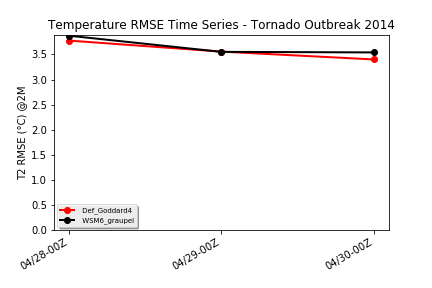

In [6]:
#where to put the output plots
plotsDir = nevsRoot + '/MET_output/skill_plots'

#------------------------------------------------------------------------------------------
#Create the output directory, if necessary
distutils.dir_util.mkpath(plotsDir)

os.chdir(plotsDir)
inputRootDir = nevsRoot + '/' + PointStatOutputDirectory

#Start the scripts
runRSME = skillScriptsDir + '/jplotMET_T2-Q2_RMSE-Bias.py'
%run -i $runRSME 
runSkill = skillScriptsDir + '/jplotMET_T2-Q2_SkillScores.py'
%run -i $runSkill

print ( "\nAll processes complete!  Find output PDF files in: \n"+ plotsDir +"\n Sample plot:")
from IPython.display import Image
Image(filename='Temp-2m_RMSE.png')
#Image(filename='Temp-2m_HeidkeSkillScore.png')
#Image(filename='Temp-2m_H-KDiscriminant.png')

<a id='gridstat'></a>
## Compare NU-WRF with gridded precip observations 
(You must have gridded STAGE IV Precip data in GRIB format to run this)

### Step 7.  Summing precip totals with Pcp-Combine

The default field to compare is currently 24-hour precipitation. To prepare for this, we will first have to run MET's Pcp-Combine tool to sum the 1-hour precip totals in the gridded observations files. The code below will create a SLURM file to submit all the jobs at once.


In [4]:
#Specify prefix of gridded filenames (probably "ST4.")
griddedObsPrefix = "ST4."
MET_Dir = '/discover/nobackup/projects/nu-wrf/members/bvanaart/SkillScoreRuns/met-5.1'
#------------------------------------------------------------------------------------------
#Run pcp_combine from inside nevsRoot + griddedObsDir (defined at top)
os.chdir(nevsRoot + '/' + griddedObsDir)

#Remove existing SLURM output file, so we can use its existence to check for job completion
SLURMlog = nevsRoot + '/' + griddedObsDir + 'pcp_combine_log'
if os.path.exists(SLURMlog):
    os.remove(SLURMlog)
    
slurmScript = nevsRoot + '/' + griddedObsDir + 'SBATCH_pcp_combine_24.bash'
runFile = open(slurmScript, 'w')
runFile.write('#!/bin/bash\n')
runFile.write('#SBATCH -J pcp_combine_24\n')
runFile.write('#SBATCH -o pcp_combine_log\n')
runFile.write('#SBATCH --constraint=' + nodeType + '\n')
runFile.write('#SBATCH --nodes=1\n')
runFile.write('#SBATCH --qos=' + myQoS + '\n')
runFile.write('#SBATCH --time=0:20:00\n')
runFile.write('#SBATCH --account=' + myAcct + '\n')
runFile.write('. /usr/share/modules/init/bash\n')
runFile.write('module purge\n')
#runFile.write('module load comp/intel-13.1.3.192\n')
runFile.write('ulimit -s unlimited\n')

outputFiles = []
#Loop through fcstDate list to set up appropriate pcp_combine commands
for i, fcstDate in enumerate(fileDate):
    #Skip 0-hr forecast date/time
    if i > 0:
        cmd = (MET_Dir + '/bin/pcp_combine -pcprx ' + griddedObsPrefix + ' -sum 00000000_000000 1 '
               + fcstDate + ' 24 ' + fcstDate[:8] + '_00_24hr &\n')
        runFile.write(cmd)
        outputFiles.append(fcstDate[:8] + '_00_24hr')
        
runFile.write('# wait for all background processes to complete.\n')
runFile.write('wait\n')
runFile.write('echo \"execution completed\"\n')
runFile.write('exit 0\n')
runFile.close()

#lastOutFile = cmd[-19:-3]
#print ( "Last 24-hr precip file created: " + lastOutFile)

# Submit this script we just created to Discover's SLURM batch processing
print ("Submitting script: " + slurmScript    )
process = subprocess.Popen(['sbatch', slurmScript], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Wait for the final line of SLURM log file to show: Job Stopped <time>
print ("Waiting for SLURM job to begin...", end='')
while not os.path.exists(SLURMlog):
    print (".", end='')
    time.sleep(5)
print ("Found " + SLURMlog)
print ("Waiting for pcp_combine to complete..", end='')
while not 'Job Stopped' in open(SLURMlog).read():
    print (".", end='')
    time.sleep(5)
print (subprocess.check_output(['tail', '-4', SLURMlog], universal_newlines=True))

# Check if all expected output files were created
if all(filenames in open(SLURMlog).read() for filenames in outputFiles):
    print ("Completed Successfully!")
else:
    print ("Error running Pcp-Combine")
    print ("Check run log at: " + SLURMlog)


Submitting script: /discover/nobackup/bvanaart/nevs/obs/st4pcp/SBATCH_pcp_combine_24.bash
Waiting for SLURM job to begin.....................Found /discover/nobackup/bvanaart/nevs/obs/st4pcp/pcp_combine_log
Waiting for pcp_combine to complete.............................................
  Job Stopped		: Thu Mar 21 17:08:08 EDT 2019
_____________________________________________________________________


Completed Successfully!


### Step 8. Prepare NU-WRF 24-hour precip files 

Your NU-WRF output may not have the required 24-hour accumulated precip fields (APCP_24). If not, the below code can use Pcp-Combine to create the necessary NetCDF files. It will use the total accumulated precip field (RAINNC) to create new files containing 24-hr precip fields (RAINNC0_24).

In [5]:
# Loop through all nuwrfRunDirs to run pcp_combine in each of their subdirectories.
for eachDir in nuwrfRunDirs:
    os.chdir(nevsRoot + '/' + eachDir + relativePath)
    # Delete existing SLURM stdout files, so we can use their existence to check for completion
    if os.path.exists('PcpCombine_Log'):
        os.remove('PcpCombine_Log')

    slurmScript = nevsRoot + "/" + eachDir + relativePath + 'SBATCH_pcp_combine_wrf24'
    runFile = open(slurmScript, 'w')
    runFile.write('#!/bin/bash\n')
    runFile.write('#SBATCH -J pcpcombine_' + eachDir + '\n')
    runFile.write('#SBATCH -o PcpCombine_Log\n')
    runFile.write('#SBATCH --constraint=' + nodeType + '\n')
    runFile.write('#SBATCH --nodes=1\n')
    runFile.write('#SBATCH --qos=' + myQoS + '\n')
    runFile.write('#SBATCH --time=0:20:00\n')
    runFile.write('#SBATCH --account=' + myAcct + '\n')
    runFile.write('. /usr/share/modules/init/bash\n')
    runFile.write('module purge\n')
    runFile.write('module load comp/intel-13.1.3.192\n')
    runFile.write('ulimit -s unlimited\n')

    #Loop through fcstDate list to set up appropriate pcp_combine commands
    for i, fcstDate in enumerate(fileDate):
        #Skip 0-hr forecast date/time
        if i > 0:
            cmd = (MET_Dir + '/bin/pcp_combine -subtract ' + nuwrfFiles[i] + 
                ' \'name=\"RAINNC\"; level=\"(0,*,*)\";\' ' + nuwrfFiles[i-1] + 
                ' \'name=\"RAINNC\"; level=\"(0,*,*)\";\' ' + fcstDate + '_00_24hr_pcp &\n')
            runFile.write(cmd)
        
    runFile.write('# wait for all background processes to complete.\n')
    runFile.write('wait\n')
    runFile.write('echo \"execution completed\"\n')
    runFile.write('exit 0\n')
    runFile.close()

    # Submit this script we just created to Discover's SLURM batch processing
    print ("Submitting script: " + slurmScript)
    process = subprocess.Popen(['sbatch', slurmScript], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Wait for the final line of each SLURM log file to show: Job Stopped <time>
for eachDir in nuwrfRunDirs:
    SLURMlog = nevsRoot + "/" + eachDir + relativePath + "PcpCombine_Log"
    print ("Waiting for SLURM job to begin...", end='')
    while not os.path.exists(SLURMlog):
        print (".", end='')
        time.sleep(5)
    print ( "Found PcpCombine_Log; job is running.")
    print ( "Waiting for Pcp-Combine to complete...", end='')
    while not 'Job Stopped' in open(SLURMlog).read():
        print (".", end='')
        time.sleep(5)
    print (subprocess.check_output(['tail', '-4', SLURMlog], universal_newlines=True))
    if 'execution completed' in open(SLURMlog).read():
        print ("Completed Successfully!\n")
    else:
        print ("Error running Pcp-Combine")


Submitting script: /discover/nobackup/bvanaart/nevs/round0_default/SBATCH_pcp_combine_wrf24
Submitting script: /discover/nobackup/bvanaart/nevs/round1_mp_physics_6/SBATCH_pcp_combine_wrf24
Waiting for SLURM job to begin.............Found PcpCombine_Log; job is running.
Waiting for Pcp-Combine to complete.....
  Job Stopped		: Thu Mar 21 17:09:18 EDT 2019
_____________________________________________________________________


Completed Successfully!

Waiting for SLURM job to begin...Found PcpCombine_Log; job is running.
Waiting for Pcp-Combine to complete...
  Job Stopped		: Thu Mar 21 17:09:17 EDT 2019
_____________________________________________________________________


Completed Successfully!



### Step 9. Running Grid-Stat

The current Grid-Stat settings are in this configuration file:
nevsRoot + /METconfig/GridStatConfig

You may want to verify that 24-hr precip field names in the obs and forecast files match those specified in GridStatConfig. The command "ncdump -h <filename>" will list the field names. The default config assumes that NU-WRF field RAINNCO_24 corresponds to ST4PRECIP field APCP_24

The code below will run Grid-Stat on each of the NU-WRF forecast test cases. It will use the values of griddedObsDir and nevsRoot, which were defined above.

In [6]:
# Specify the output directory for the Grid-Stat files, relative to nevsRoot
GridStatOutputDir = "MET_output/GridStat/"

#------------------------------------------------------------------------------------------
# Create SLURM Grid-Stat runscripts for each NU-WRF ensemble case
os.chdir(skillScriptsDir)
for eachDir in nuwrfRunDirs:
    #Create the output directories, if necessary
    distutils.dir_util.mkpath(nevsRoot + '/' + GridStatOutputDir + eachDir)
    distutils.dir_util.mkpath(skillScriptsDir + '/logs')
    
    #Remove existing SLURM output files, so we can use their existence to check for completion
    #print ( skillScriptsDir + "/GridStatLog" + eachDir)
    if os.path.exists(skillScriptsDir + "/logs/GridStatLog_" + eachDir):
        os.remove(skillScriptsDir + "/logs/GridStatLog_" + eachDir)
    
    slurmScript = skillScriptsDir + '/tmp/jrun_GStat_' + eachDir + '.bash'
    runFile = open(slurmScript, 'w')
    runFile.write('#!/bin/bash\n')
    runFile.write('#SBATCH -J GridStat' + eachDir + '\n')
    runFile.write('#SBATCH -o logs/GridStatLog_' + eachDir + '\n')
    runFile.write('#SBATCH --constraint=' + nodeType + '\n')
    runFile.write('#SBATCH --nodes=1\n')
    runFile.write('#SBATCH --qos=' + myQoS + '\n')
    runFile.write('#SBATCH --time=0:20:00\n')
    runFile.write('#SBATCH --account=' + myAcct + '\n')
    runFile.write('. /usr/share/modules/init/bash\n')
    runFile.write('module purge\n')
    runFile.write('module load comp/intel-13.1.3.192\n')
    runFile.write('ulimit -s unlimited\n')
    runFile.write('cd ' + nevsRoot + '\n')
    # Write Grid-Stat execution command for all forecast periods except first, which
    # is assumed to be the 0-hour (initialization) forecast.
    for i, fcstPeriod in enumerate(fileDate):
        if i > 0:
            runFile.write(MET_Dir + '/bin/grid_stat ' + eachDir + relativePath + str(fcstPeriod) +
                      '_00_24hr_pcp ' + griddedObsDir + str(fcstPeriod)[:8] + '_00_24hr ' + nevsRoot + 
                      '/METconfig/GridStatConfig -outdir ' + GridStatOutputDir + eachDir + ' &\n')
    runFile.write('# wait for all background processes to complete.\n')
    runFile.write('wait\n')
    runFile.write('echo \"execution completed\"\n')
    runFile.write('exit 0\n')
    runFile.close()

    # Submit this script we just created to Discover's SLURM batch processing
    print ( "Submitting script: " + slurmScript    )
    process = subprocess.Popen(['sbatch', slurmScript], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Wait for the final line of each SLURM log file to show: Job Stopped <time>
for eachDir in nuwrfRunDirs:
    SLURMlog = nevsRoot + "/scripts/logs/GridStatLog_" + eachDir
    print ("Waiting for SLURM job to begin...", end='')
    while not os.path.exists(SLURMlog):
        print (".", end='')
        time.sleep(5)
    print ("Found GridStatLog_" + eachDir + "; Job is running.")
    print ("Waiting for Grid-Stat to complete...", end='')
    while not 'Job Stopped' in open(SLURMlog).read():
        print (".", end='')
        time.sleep(5)
    print (subprocess.check_output(['tail', '-4', SLURMlog], universal_newlines=True))
    if 'execution completed' in open(SLURMlog).read():
        print ("Completed Successfully!\n")
    else:
        print ("Error running GridStat")


Submitting script: /gpfsm/dnb32/bvanaart/nevs/scripts/tmp/jrun_GStat_round0_default.bash
Submitting script: /gpfsm/dnb32/bvanaart/nevs/scripts/tmp/jrun_GStat_round1_mp_physics_6.bash
Waiting for SLURM job to begin..........................Found GridStatLog_round0_default
Waiting for Grid-Stat to complete....
  Job Stopped		: Thu Mar 21 17:12:42 EDT 2019
_____________________________________________________________________


Completed Successfully!

Waiting for SLURM job to begin...Found GridStatLog_round1_mp_physics_6
Waiting for Grid-Stat to complete...
  Job Stopped		: Thu Mar 21 17:12:42 EDT 2019
_____________________________________________________________________


Completed Successfully!



### Step 10. Plot Basic Statistics from Grid-Stat output

Use Python Matplotlib to graph RMSE, Bias, Correlation, and Skill Scores from Grid-Stat output. This version will plot stats for Temperature and Specific Humidity @ 2-meters above the surface 

Uses Python scripts at: nevsRoot + /scripts/jplotMET_Precip*
along with data from:   nevsRoot + MET_output/GridStat/<nuwrfRunDirs>


numPeriods = 5
2014-04-28-00Z
2014-04-29-00Z
2014-04-30-00Z
2014-05-01-00Z
2014-05-02-00Z
numPeriods = 5
1 day, 0:00:00
2014-04-28-00Z
2014-04-29-00Z
2014-04-30-00Z
2014-05-01-00Z
2014-05-02-00Z
All processes complete!  Find output PDF files in: 
/discover/nobackup/bvanaart/nevs/MET_output/skill_plots
 Sample plot:


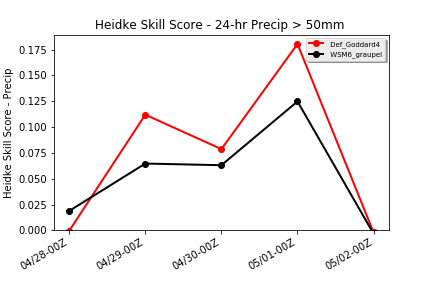

In [7]:
# Where the output plots should be stored (Probably the same place as Point-Stat plots above).
plotsDir = nevsRoot + '/MET_output/skill_plots'

#------------------------------------------------------------------------------------------
#Create the output directory, if necessary
if not os.path.exists(plotsDir):
    os.mkdir(plotsDir)

os.chdir(plotsDir)
inputRootDir = nevsRoot + '/' + GridStatOutputDir

#Start the scripts
runRSME = skillScriptsDir + '/jplotMET_Precip-RMSE-Bias.py'
%run -i $runRSME 
runSkill = skillScriptsDir + '/jplotMET_Precip-SkillScores.py'
%run -i $runSkill

print ( "All processes complete!  Find output PDF files in: \n"+ plotsDir +"\n Sample plot:")
from IPython.display import Image
Image(filename='Precip50mm_HeidkeSkillScore.png')


# Additional Info
<a id='gettingObs'></a>
## Downloading Observations
### 1) Getting Point Observations (PREPBUFR data in netcdf format) 
    a.	Go to http://rda.ucar.edu/datasets/ds337.0/
    b.	Make sure you’re logged-in (create an account, if necessary)
    c.	Click on “Data Access” tab from lower row of tabs
    d.	Click “Web File Listing” on row “Union of Available Products”, column “Web Server Holdings”
    e.	Click “Faceted Browse”
    f.	Change Temporal Selection to appropriate time period (i.e., 2014-04-27 to 2104-05-03)
    g.	Use map tool: click “Draw Box” radio-button beneath map, and enter N: 57, W: -132, E: -58, S: 10
    h.	Click “Continue”
    i.	Download list given in table on subsequent page, preferably using wget with provided Unix Script to download from Discover (must have rda.ucar.edu username/password set in script). Files will be named like:
        prepbufr.20140427.nr.tar.gz
    j.	Untar the files into your desired subdirectory (i.e., <nevsRoot>/obs/gdas_point_obs). 
        The resulting filenames will resemble this:
        prepbufr.gdas.152117.2014042700.nc
        prepbufr.gdas.152117.2014042706.nc
        prepbufr.gdas.152117.2014042712.nc
        prepbufr.gdas.152117.2014042718.nc  … etc.

### 2) Download Gridded STAGE IV Precip Observations from NCAR/UCAR EOL
    a.	Go to http://data.eol.ucar.edu/cgi-bin/codiac/fgr_form/id=21.093
    b.	Order data for appropriate time period (begin a full day before forecast validation time); 
    c.	Select *.tar.gz output.
    d.	Enter email address; they will send download info (ftp or link to download).  
    e.	Save downloaded data to desired Discover subdirectory (i.e., <nevsRoot>/obs/st4precip)